# Advanced Regression Assignment

<b>Problem Statement</b></br>
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. </br>
For the same purpose, the company has collected a data set from the sale of houses in Australia. The company is looking at prospective properties to buy to enter the market. </br>
You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.</br>
The company wants to know:
- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

## Step1: Reading and Understanding the data

In [1]:
# Import all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset

house_df = pd.read_csv('train.csv')
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Shape of the dataset

house_df.shape

(1460, 81)

#### No. of rows = 1460
#### No. of columns = 81

In [4]:
# checking the datatypes in the dataset
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Observed that there are missing values for the below columns
- Alley       
- BsmtQual    
- BsmtCond    
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- Electrical  
- FireplaceQu 
- GarageType  
- GarageYrBlt 
- GarageFinish
- GarageQual  
- GarageCond  
- PoolQC      
- Fence       
- MiscFeature 

### Step 2: Data Cleansing

In [5]:
# Dropping Id column as it is just an identity column

house_df.drop('Id', axis=1, inplace=True)

In [6]:
# Dropping all the columns which have only NA values in all rows

total_rows = house_df.shape[0]

house_df = house_df.loc[:, (house_df.isnull().sum() < total_rows)]

In [7]:
house_df.shape

(1460, 80)

In [8]:
# Check missing values in all columns

house_df.isnull().sum()[house_df.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [9]:
# Missing value imputation of LotFrontage with median

house_df['LotFrontage'] = house_df['LotFrontage'].fillna(house_df['LotFrontage'].median())

In [10]:
house_df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [11]:
house_df['MasVnrArea'].value_counts()

0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64

In [12]:
house_df[house_df['MasVnrType'].isnull()][['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [13]:
# replacing the missing values
# MasVnrArea with 0 
# MasVnrType with 'None'

house_df['MasVnrType'] = house_df['MasVnrType'].fillna('None')
house_df['MasVnrArea'] = house_df['MasVnrArea'].fillna(0)

In [14]:
house_df[house_df[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isnull()][['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1455,NaN,NaN,NaN,NaN,NaN
1456,NaN,NaN,NaN,NaN,NaN
1457,NaN,NaN,NaN,NaN,NaN
1458,NaN,NaN,NaN,NaN,NaN


In [15]:
# replacing the 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' columns with 'None' for "No Basement"

house_df['BsmtQual'] = house_df['BsmtQual'].fillna('None')
house_df['BsmtCond'] = house_df['BsmtCond'].fillna('None')
house_df['BsmtExposure'] = house_df['BsmtExposure'].fillna('None')
house_df['BsmtFinType1'] = house_df['BsmtFinType2'].fillna('None')
house_df['BsmtFinType2'] = house_df['BsmtFinType2'].fillna('None')

In [16]:
# replacing 'NA' values of 'Alley' with None for "No alley access"
# replacing 'NA' values of 'PoolQC' with None for "No Pool"
# replacing 'NA' values of 'Fence' with None for "No Fence"
# replacing 'NA' values of 'MiscFeature' with "None"

house_df['Alley'] = house_df['Alley'].fillna('None')
house_df['PoolQC'] = house_df['PoolQC'].fillna('None')
house_df['Fence'] = house_df['Fence'].fillna('None')
house_df['MiscFeature'] = house_df['MiscFeature'].fillna('None')

In [17]:
# Missing value imputation of Electical with mode as it is categorical variable

house_df['Electrical'] = house_df['Electrical'].fillna(house_df['Electrical'].mode()[0])

In [18]:
house_df[house_df['FireplaceQu'].isnull()][['Fireplaces', 'FireplaceQu']]

,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN
12,0,NaN
15,0,NaN
...,...,...
1452,0,NaN
1453,0,NaN
1454,0,NaN
1458,0,NaN


In [19]:
# replacing the missing values for FireplaceQu with 'None' for "No Fireplace"

house_df['FireplaceQu'] = house_df['FireplaceQu'].fillna('None')

In [20]:
house_df[house_df[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt']].isnull()][['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt']]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1455,NaN,NaN,NaN,NaN,NaN
1456,NaN,NaN,NaN,NaN,NaN
1457,NaN,NaN,NaN,NaN,NaN
1458,NaN,NaN,NaN,NaN,NaN


In [21]:
# replacing the missing values for 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond' with 'None' for "No Garage"

house_df['GarageType'] = house_df['GarageType'].fillna('None')
house_df['GarageFinish'] = house_df['GarageFinish'].fillna('None')
house_df['GarageQual'] = house_df['GarageQual'].fillna('None')
house_df['GarageCond'] = house_df['GarageCond'].fillna('None')

In [22]:
# For missing values of GarageYrBlt (as there is no garage for these records) will replace with 
# corresponding 'YearBuilt' column value

house_df['GarageYrBlt'] = house_df['GarageYrBlt'].fillna(house_df.YearBuilt)

In [23]:
house_df.isnull().sum()[house_df.isnull().sum()>0]

Series([], dtype: int64)

#### All the missing values are imputed successfully

In [24]:
# Converting the year columns to no. of years

house_df['BuiltYears'] = date.today().year - house_df['YearBuilt']
house_df['GarageBuiltYears'] = date.today().year - house_df['GarageYrBlt']
house_df['RemodelYears'] = date.today().year - house_df['YearRemodAdd']

# changing the datatype to int64 for the new columns
house_df['BuiltYears'] = house_df['BuiltYears'].astype('int64')
house_df['GarageBuiltYears'] = house_df['GarageBuiltYears'].astype('int64')
house_df['RemodelYears'] = house_df['RemodelYears'].astype('int64')

# Drop the original variables
house_df.drop(['YearBuilt', 'GarageYrBlt', 'YearRemodAdd'], axis=1, inplace=True)

In [25]:
# Fix the datatypes of some numerical variables which should have been categorical variables
# MSSubClass, OverallQual,  OverallCond, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, 
# TotRmsAbvGrd, Fireplaces, GarageCars, YearBuilt, GarageYrBlt, YearRemodAdd, MoSold, YrSold

house_df['MSSubClass'] = house_df['MSSubClass'].astype('object')
house_df['OverallQual'] = house_df['OverallQual'].astype('object')
house_df['OverallCond'] = house_df['OverallCond'].astype('object')
house_df['BsmtFullBath'] = house_df['BsmtFullBath'].astype('object')
house_df['BsmtHalfBath'] = house_df['BsmtHalfBath'].astype('object')
house_df['FullBath'] = house_df['FullBath'].astype('object')
house_df['HalfBath'] = house_df['HalfBath'].astype('object')
house_df['BedroomAbvGr'] = house_df['BedroomAbvGr'].astype('object')
house_df['KitchenAbvGr'] = house_df['KitchenAbvGr'].astype('object')
house_df['Fireplaces'] = house_df['Fireplaces'].astype('object')
house_df['GarageCars'] = house_df['GarageCars'].astype('object')
house_df['MoSold'] = house_df['MoSold'].astype('object')
house_df['YrSold'] = house_df['YrSold'].astype('object')

In [26]:
# Get all the numeric variables from the dataset

numeric_vars = list(house_df.select_dtypes(include=('int64', 'float64')).columns)
numeric_vars

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SalePrice',
 'BuiltYears',
 'GarageBuiltYears',
 'RemodelYears']

In [27]:
house_df.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,BuiltYears,GarageBuiltYears,RemodelYears
1173,50,RL,138.0,18030,Pave,None,IR1,Bnk,AllPub,Inside,...,None,0,3,2007,WD,Normal,200500,76,76,28
1283,90,RL,94.0,9400,Pave,None,Reg,Low,AllPub,Corner,...,None,0,4,2010,WD,Normal,139000,51,51,51
776,20,RL,86.0,11210,Pave,None,IR1,Lvl,AllPub,Inside,...,None,0,7,2006,New,Partial,221500,17,17,16
975,160,FV,69.0,2651,Pave,None,Reg,Lvl,AllPub,FR2,...,None,0,4,2006,WD,Normal,165000,22,22,22
568,50,RL,79.0,12327,Pave,None,IR1,Low,AllPub,Inside,...,None,0,9,2009,WD,Normal,316600,39,39,13


### Step 3: Data Visualization

In [28]:
# Checking the percentiles for all numeric variables
house_df.describe(percentiles=[.25,.50,.75,.95,.99])

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,BuiltYears,GarageBuiltYears,RemodelYears
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,69.863699,10516.828082,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,...,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890,50.732192,45.492466,37.134247
std,22.027677,9981.264932,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,...,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883,30.202904,26.306739,20.645407
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,12.000000,12.000000,12.000000
25%,60.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000,22.000000,21.000000,18.000000
50%,69.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,...,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000,49.000000,44.000000,28.000000
75%,79.000000,11601.500000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000,68.000000,63.000000,55.000000
95%,104.000000,17401.150000,456.000000,1274.000000,396.200000,1468.000000,1753.000000,1831.250000,1141.050000,0.000000,...,175.050000,180.150000,0.000000,160.000000,0.000000,0.000000,326100.000000,106.000000,98.000000,72.000000
99%,137.410000,37567.640000,791.280000,1572.410000,830.380000,1797.050000,2155.050000,2219.460000,1418.920000,360.000000,...,285.820000,261.050000,168.000000,268.050000,0.000000,700.000000,442567.010000,122.820000,111.410000,72.000000
max,313.000000,215245.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,...,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000,150.000000,150.000000,72.000000


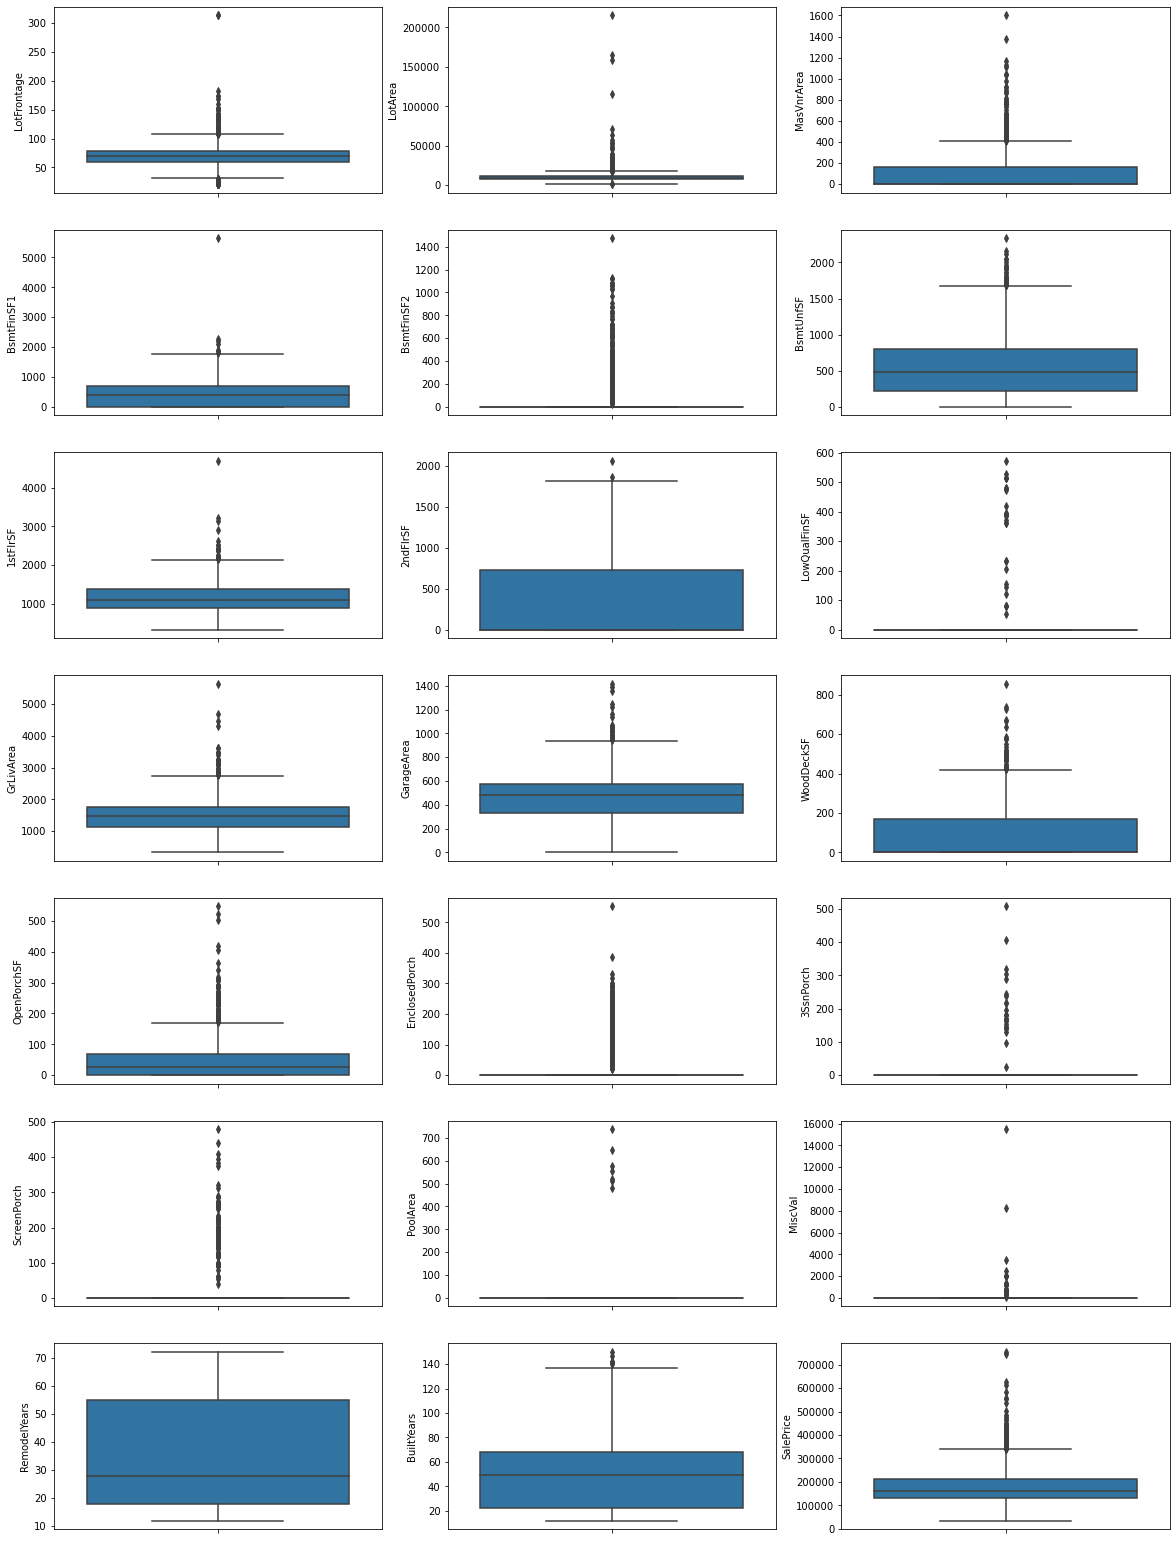

In [29]:
# Plotting box plots to check the outliers
plt.figure(figsize=(20, 28))
plt.subplot(7,3,1)
sns.boxplot(y = 'LotFrontage', data = house_df)
plt.subplot(7,3,2)
sns.boxplot(y = 'LotArea', data = house_df)
plt.subplot(7,3,3)
sns.boxplot(y = 'MasVnrArea', data = house_df)
plt.subplot(7,3,4)
sns.boxplot(y = 'BsmtFinSF1', data = house_df)
plt.subplot(7,3,5)
sns.boxplot(y = 'BsmtFinSF2', data = house_df)
plt.subplot(7,3,6)
sns.boxplot(y = 'BsmtUnfSF', data = house_df)
plt.subplot(7,3,7)
sns.boxplot(y = '1stFlrSF', data = house_df)
plt.subplot(7,3,8)
sns.boxplot(y = '2ndFlrSF', data = house_df)
plt.subplot(7,3,9)
sns.boxplot(y = 'LowQualFinSF', data = house_df)
plt.subplot(7,3,10)
sns.boxplot(y = 'GrLivArea', data = house_df)
plt.subplot(7,3,11)
sns.boxplot(y = 'GarageArea', data = house_df)
plt.subplot(7,3,12)
sns.boxplot(y = 'WoodDeckSF', data = house_df)
plt.subplot(7,3,13)
sns.boxplot(y = 'OpenPorchSF', data = house_df)
plt.subplot(7,3,14)
sns.boxplot(y = 'EnclosedPorch', data = house_df)
plt.subplot(7,3,15)
sns.boxplot(y = '3SsnPorch', data = house_df)
plt.subplot(7,3,16)
sns.boxplot(y = 'ScreenPorch', data = house_df)
plt.subplot(7,3,17)
sns.boxplot(y = 'PoolArea', data = house_df)
plt.subplot(7,3,18)
sns.boxplot(y = 'MiscVal', data = house_df)
plt.subplot(7,3,19)
sns.boxplot(y = 'RemodelYears', data = house_df)
plt.subplot(7,3,20)
sns.boxplot(y = 'BuiltYears', data = house_df)
plt.subplot(7,3,21)
sns.boxplot(y = 'SalePrice', data = house_df)
plt.show()

<b>Insights</b>
- Can see most independent variables have outliers. 
- Can see some outliers in target variable "SalesPrice" as well

#### Outlier Treatment

In [30]:
# Picking columns which have a lot of outliers and removing data points beyond 99% 

house_df = house_df[house_df.LotArea < house_df.LotArea.quantile(0.99)]
house_df = house_df[house_df.MasVnrArea < house_df.MasVnrArea.quantile(0.99)]
house_df = house_df[house_df.BsmtFinSF2 < house_df.BsmtFinSF2.quantile(0.99)]
house_df = house_df[house_df.ScreenPorch < house_df.ScreenPorch.quantile(0.99)]
house_df = house_df[house_df.EnclosedPorch < house_df.EnclosedPorch.quantile(0.99)]
house_df = house_df[house_df['3SsnPorch'] < house_df['3SsnPorch'].quantile(0.99)]
house_df = house_df[house_df.OpenPorchSF < house_df.OpenPorchSF.quantile(0.99)]
house_df = house_df[house_df.WoodDeckSF < house_df.WoodDeckSF.quantile(0.99)]
house_df = house_df[house_df.MiscVal < house_df.MiscVal.quantile(0.99)]
house_df = house_df[house_df.GrLivArea < house_df.GrLivArea.quantile(0.99)]
house_df = house_df[house_df.GarageArea < house_df.GarageArea.quantile(0.99)]
house_df = house_df[house_df.SalePrice < house_df.SalePrice.quantile(0.99)]

In [31]:
house_df.shape

(1286, 80)

In [32]:
# No. of records removed 
# Almost 11% of the data is removed. So, not doing any further outlier treatment
(1460 - 1286)*100/(1460)

11.917808219178083

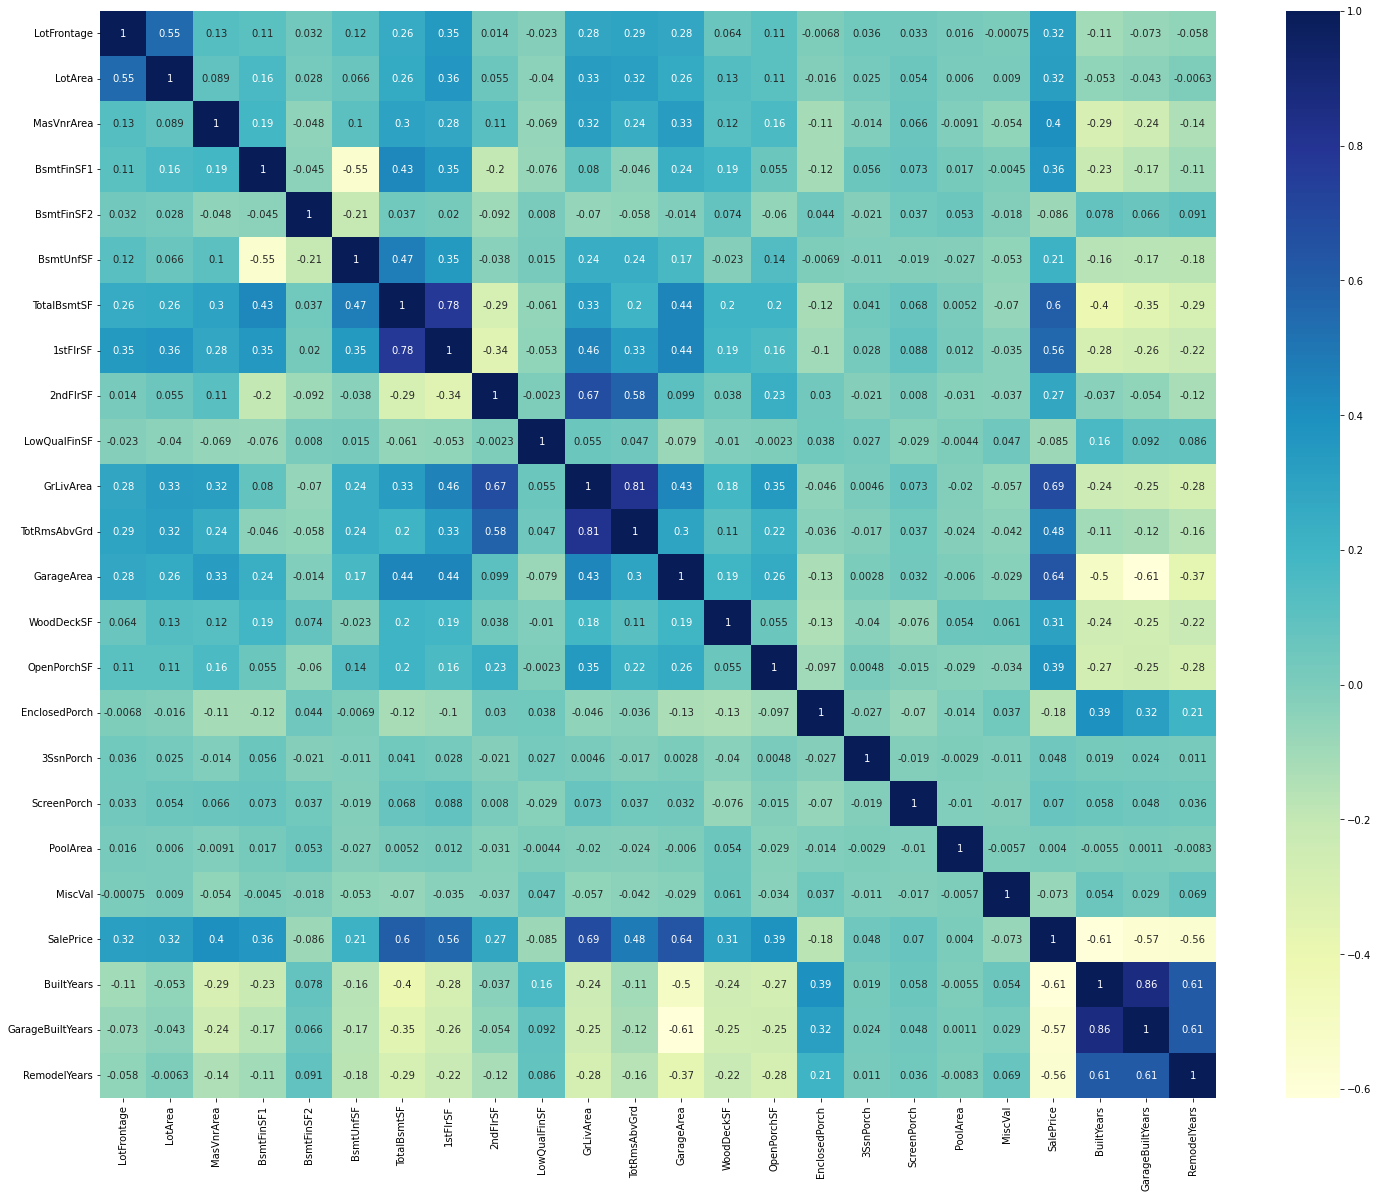

In [33]:
# Plotting the heatmap for numeric variables to see the correlation

plt.figure(figsize=(25,20))
sns.heatmap(house_df[numeric_vars].corr(), annot=True, cmap='YlGnBu')
plt.show()

Observed strong correlations for following:
- GarageBuiltYears and BuiltYears with 0.86
- TotRmsAbvGrd and GrLivArea with 0.81.
- TotalBsmtSF and 1stFirSF with 0.78.

In [34]:
# Dropping the variables with high correlation
# GarageBuiltYears and BuiltYears with 0.86
# TotRmsAbvGrd and GrLivArea with 0.81. Also this is a total column
# TotalBsmtSF and 1stFirSF with 0.78. Also this is a total column

house_df.drop(['GarageBuiltYears', 'TotRmsAbvGrd', 'TotalBsmtSF'], axis=1, inplace=True)
numeric_vars = list(set(numeric_vars) - set(['GarageBuiltYears', 'TotRmsAbvGrd', 'TotalBsmtSF']))
numeric_vars

['OpenPorchSF',
 'BsmtFinSF1',
 'EnclosedPorch',
 'BsmtFinSF2',
 'LotFrontage',
 'LotArea',
 'BsmtUnfSF',
 'LowQualFinSF',
 'WoodDeckSF',
 '3SsnPorch',
 '2ndFlrSF',
 'ScreenPorch',
 'GarageArea',
 'RemodelYears',
 'SalePrice',
 'PoolArea',
 'MiscVal',
 'GrLivArea',
 'MasVnrArea',
 '1stFlrSF',
 'BuiltYears']

In [35]:
house_df.shape

(1286, 77)

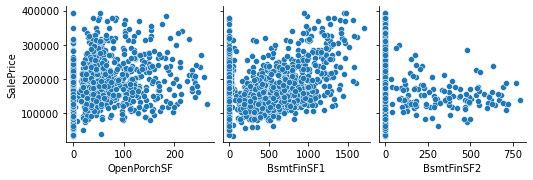

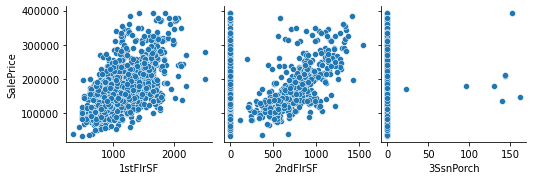

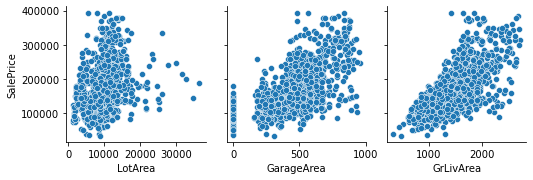

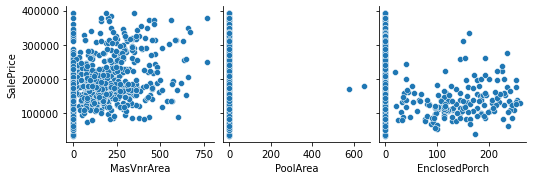

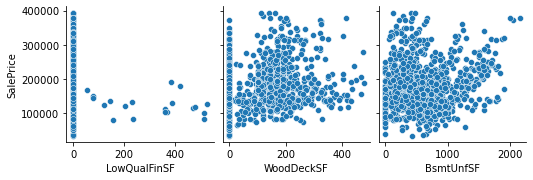

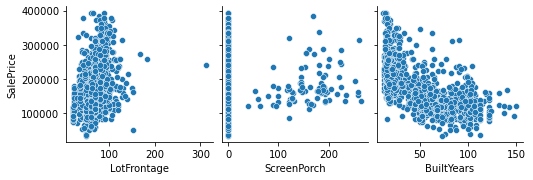

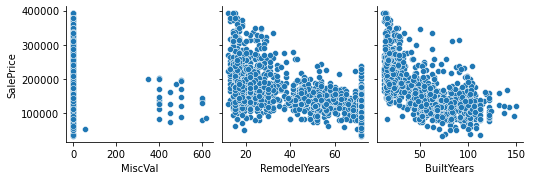

In [36]:
# Plotting scatter plots for all numeric variables

sns.pairplot(house_df, x_vars=["OpenPorchSF", "BsmtFinSF1", "BsmtFinSF2"], y_vars = "SalePrice")
sns.pairplot(house_df, x_vars = ["1stFlrSF", "2ndFlrSF", "3SsnPorch"],  y_vars = "SalePrice")
sns.pairplot(house_df, x_vars = ["LotArea", "GarageArea", "GrLivArea"],  y_vars = "SalePrice")
sns.pairplot(house_df, x_vars = ["MasVnrArea", "PoolArea", "EnclosedPorch"],  y_vars = "SalePrice")
sns.pairplot(house_df, x_vars = ["LowQualFinSF", "WoodDeckSF", "BsmtUnfSF"],  y_vars = "SalePrice")
sns.pairplot(house_df, x_vars = ["LotFrontage", "ScreenPorch", "BuiltYears"],  y_vars = "SalePrice")
sns.pairplot(house_df, x_vars = ["MiscVal", "RemodelYears", "BuiltYears"],  y_vars = "SalePrice")

<b>Insights</b>
- A few independent variables like '1stFlrSF','GrLivArea','GarageArea','2ndFlrSF', 'BsmtFinSF1' seems to have a linear relationship 
 with dependent variable 'SalesPrice'
- Rest of the variables are a little scattered

In [37]:
# categorical variables

categorical_vars = list(house_df.select_dtypes(include='object').columns)
categorical_vars

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

#### Visualizing categorical variables

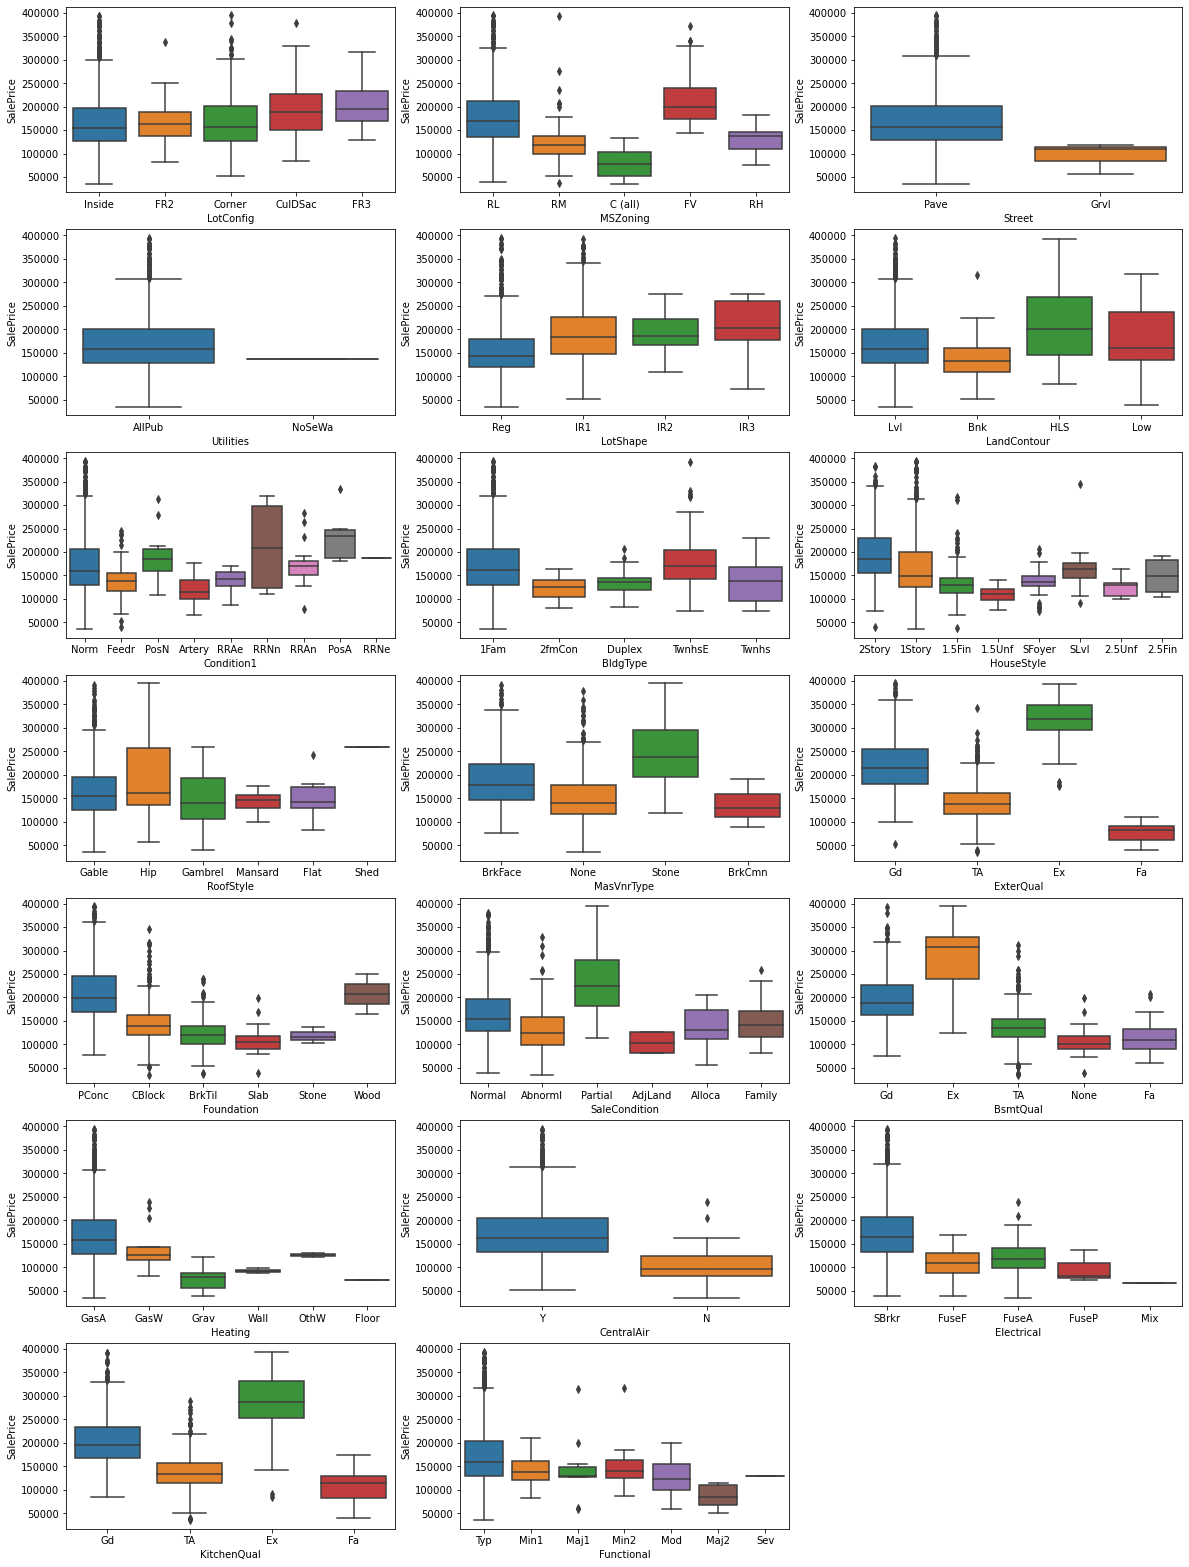

In [38]:
# Plotting box plots for a few categorical variables

plt.figure(figsize=(20, 28))
plt.subplot(7,3,1)
sns.boxplot(x = 'LotConfig', y = 'SalePrice', data = house_df)
plt.subplot(7,3,2)
sns.boxplot(x = 'MSZoning', y = 'SalePrice', data = house_df)
plt.subplot(7,3,3)
sns.boxplot(x = 'Street', y = 'SalePrice', data = house_df)
plt.subplot(7,3,4)
sns.boxplot(x = 'Utilities', y = 'SalePrice', data = house_df)
plt.subplot(7,3,5)
sns.boxplot(x = 'LotShape', y = 'SalePrice', data = house_df)
plt.subplot(7,3,6)
sns.boxplot(x = 'LandContour', y = 'SalePrice', data = house_df)
plt.subplot(7,3,7)
sns.boxplot(x = 'Condition1', y = 'SalePrice', data = house_df)
plt.subplot(7,3,8)
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = house_df)
plt.subplot(7,3,9)
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', data = house_df)
plt.subplot(7,3,10)
sns.boxplot(x = 'RoofStyle', y = 'SalePrice', data = house_df)
plt.subplot(7,3,11)
sns.boxplot(x = 'MasVnrType', y = 'SalePrice', data = house_df)
plt.subplot(7,3,12)
sns.boxplot(x = 'ExterQual', y = 'SalePrice', data = house_df)
plt.subplot(7,3,13)
sns.boxplot(x = 'Foundation', y = 'SalePrice', data = house_df)
plt.subplot(7,3,14)
sns.boxplot(x = 'SaleCondition', y = 'SalePrice', data = house_df)
plt.subplot(7,3,15)
sns.boxplot(x = 'BsmtQual', y = 'SalePrice', data = house_df)
plt.subplot(7,3,16)
sns.boxplot(x = 'Heating', y = 'SalePrice', data = house_df)
plt.subplot(7,3,17)
sns.boxplot(x = 'CentralAir', y = 'SalePrice', data = house_df)
plt.subplot(7,3,18)
sns.boxplot(x = 'Electrical', y = 'SalePrice', data = house_df)
plt.subplot(7,3,19)
sns.boxplot(x = 'KitchenQual', y = 'SalePrice', data = house_df)
plt.subplot(7,3,20)
sns.boxplot(x = 'Functional', y = 'SalePrice', data = house_df)
plt.show()

<b>Insights</b></br>
Higher SalePrice has the following:
- MSZoning as "Floating Village Residential"
- Street as "Paved"
- Utilities as "All public Utilities (E,G,W,& S)"
- Lotshape as "IR3"
- LandContour as "HLS"
- BldgType as "Townhouse End Unit" and "Single-family Detached"
- HouseStyle as "Two story"
- MasVnrType as "Stone"
- Foundation as "Wood"
- ExterQual as "Excellent"
- KitchenQual as "Excellent"
- Functional as "Typical Functionality"
- SaleCondition as "Home was not completed when last assessed (associated with New Homes)"

##### Categorical Vs Categorical variable analysis

<Figure size 1440x1296 with 0 Axes>

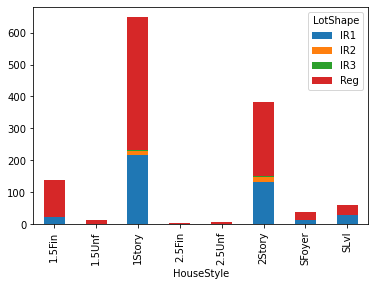

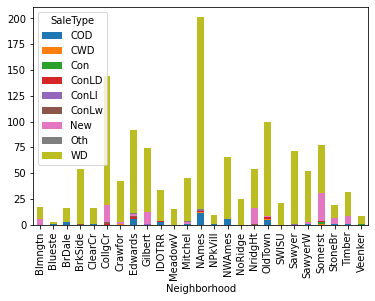

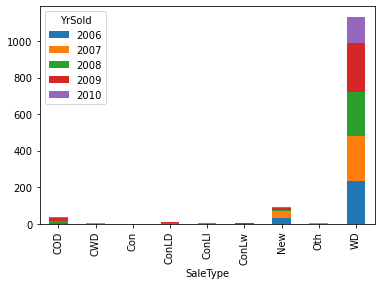

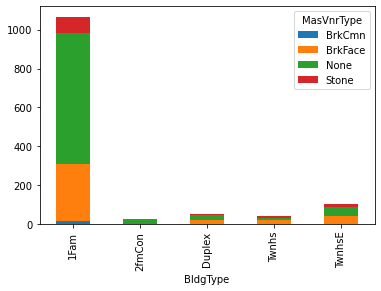

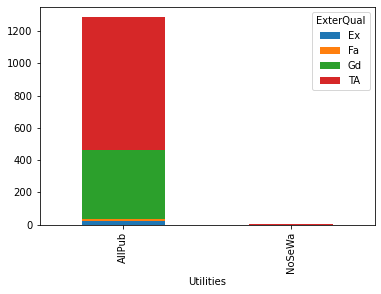

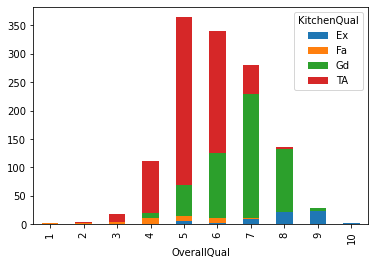

In [39]:
# A few categorical vs categorical plots
plt.figure(figsize=(20, 18))

pd.crosstab(house_df['HouseStyle'], house_df['LotShape']).plot(kind='bar', stacked=True)
pd.crosstab(house_df['Neighborhood'], house_df['SaleType']).plot(kind='bar', stacked=True)
pd.crosstab(house_df['SaleType'], house_df['YrSold']).plot(kind='bar', stacked=True)
pd.crosstab(house_df['BldgType'], house_df['MasVnrType']).plot(kind='bar', stacked=True)
pd.crosstab(house_df['Utilities'], house_df['ExterQual']).plot(kind='bar', stacked=True)
pd.crosstab(house_df['OverallQual'], house_df['KitchenQual']).plot(kind='bar', stacked=True)
plt.show()

#### Some Insights
- Most of the houses are 1story and they have regular lotshape.
- Most of the houses are 'North Ames' neightbourhood with sale type 'Warranty Deed - Conventional'
- Most of the houses are 'Single-faimily Detached' with less 'Brick Common' masonry
- Most of the houses with 'Average' and 'Above Average' OverallCond have 'Average' Kitchen.

### Step 4: Data Preprocessing

#### Creating Dummy variables

In [40]:
# Creating dummy variables for all categorical columns

categories_df = pd.get_dummies(house_df[categorical_vars], drop_first=True)
categories_df.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [41]:
# Drop the original categorical columns

house_df = house_df.drop(categorical_vars, axis=1)

In [42]:
# concatenate the original dataframe with the newly created categorical dummy variables dataframe

house_df = pd.concat([house_df, categories_df], axis=1)
house_df.shape

(1286, 307)

### Step 5: Splitting data into Train and Test sets

In [43]:
# Splitting the data into train and test sets in the ratio 80:20

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)

df_train, df_test = train_test_split(house_df, train_size=0.8, test_size=0.2, random_state=100)

print(df_train.shape)
print(df_test.shape)

(1028, 307)
(258, 307)


#### Rescaling features using Min-Max scaling

In [44]:
scaler = MinMaxScaler()

In [45]:
# Apply scaler() to all numeric columns 

df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
913,0.208904,0.141193,0.000000,0.167453,0.0,0.333024,0.304566,0.650000,0.0,0.700546,...,0,0,0,0,1,0,0,0,1,0
1177,0.164384,0.075284,0.000000,0.275943,0.0,0.162564,0.221005,0.263636,0.0,0.373793,...,0,0,0,0,1,0,0,0,1,0
378,0.229452,0.286761,0.453368,0.852005,0.0,0.190896,0.694977,0.000000,0.0,0.639227,...,0,0,1,0,0,0,0,0,0,1
1203,0.184932,0.240057,0.221503,0.000000,0.0,0.757083,0.591781,0.000000,0.0,0.544309,...,0,0,0,0,1,0,0,0,1,0
163,0.116438,0.119318,0.000000,0.000000,0.0,0.409661,0.250228,0.000000,0.0,0.230155,...,0,0,0,0,1,0,0,0,1,0


In [46]:
df_train.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,...,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000
mean,0.163271,0.230393,0.111485,0.241140,0.042403,0.264128,0.356124,0.211103,0.009285,0.466099,...,0.002918,0.002918,0.068093,0.001946,0.883268,0.003891,0.006809,0.013619,0.839494,0.070039
std,0.072222,0.112253,0.183262,0.239552,0.151923,0.204050,0.152229,0.264594,0.081152,0.181498,...,0.053969,0.053969,0.252029,0.044087,0.321256,0.062287,0.082277,0.115958,0.367253,0.255337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133562,0.169347,0.000000,0.000000,0.000000,0.103344,0.242009,0.000000,0.000000,0.325808,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.164384,0.223381,0.000000,0.211675,0.000000,0.221551,0.330137,0.000000,0.000000,0.456951,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.195205,0.281207,0.190738,0.406840,0.000000,0.378309,0.449543,0.456494,0.000000,0.580428,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividing into X and Y sets for model building

In [47]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [48]:
print(X_train.shape)
print(y_train.shape)

(1028, 306)
(1028,)


In [49]:
df_test.shape

(258, 307)

#### Scaling on test set

In [50]:
# Applying scaling on the test set
df_test[numeric_vars] = scaler.transform(df_test[numeric_vars])
df_test.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
289,0.133562,0.211080,0.0,0.000000,0.0,0.324199,0.166210,0.453247,0.0,0.446031,...,0,0,0,0,1,0,0,0,1,0
951,0.133562,0.184659,0.0,0.377948,0.0,0.086856,0.288128,0.000000,0.0,0.265015,...,0,0,0,0,1,0,0,0,0,0
32,0.219178,0.276960,0.0,0.000000,0.0,0.573154,0.410959,0.000000,0.0,0.377992,...,0,0,0,0,1,0,0,0,1,0
1183,0.133562,0.269886,0.0,0.484080,0.0,0.138876,0.363470,0.000000,0.0,0.334313,...,0,0,0,0,1,0,0,0,1,0
839,0.167808,0.297358,0.0,0.207547,0.0,0.193219,0.198174,0.280519,0.0,0.363713,...,0,0,0,0,1,0,0,0,1,0


#### Dividing test set into X and Y sets

In [51]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [52]:
print(y_test.shape)
print(X_test.shape)

(258,)
(258, 306)


### Step 6: Linear Regression Model

In [53]:
# Base Linear Regression model using SKLearn library
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [54]:
# print the intercept and first 10 coefficients
print(lm.intercept_)
print(lm.coef_[:10])

203699839847.0988
[-1.81295558e-02  1.08433051e-01  1.96361341e-02  1.56050936e-01
  6.43361574e-02  1.12506951e-01 -1.01031946e+11 -7.10452955e+10
 -2.37125207e+10  1.09843408e+11]


In [55]:
# Predictions on the basis of the model
y_train_pred = lm.predict(X_train)
y_train_pred

array([0.35464478, 0.21218872, 1.0057373 , ..., 0.42297363, 0.28845215,
       0.26431274])

In [56]:
#Calculate R2 score, RSS, MSE and RMSE for train and test sets

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_train: ", r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_test: ",r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS_train: ",rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS_test: ",rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE_train: ",mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE_test: ",mse_test_lr)
metric.append(mse_test_lr**0.5)

r2_train:  0.9551578975389197
r2_test:  -2.3036016475266246e+21
RSS_train:  1.4303813011009512
RSS_test:  1.6551886846731475e+22
MSE_train:  0.001391421499125439
MSE_test:  6.415460018112975e+19


#### Residual analysis

Text(0.5, 0, 'Errors')

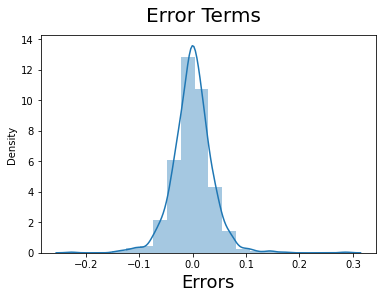

In [57]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

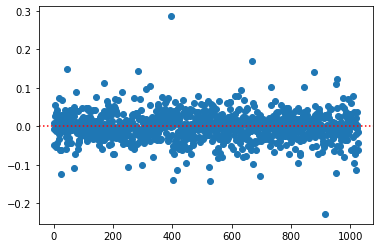

In [58]:
# Looking for patterns in the residuals

plt.scatter(np.arange(0,len(X_train),1), (y_train - y_pred_train))
plt.axhline(y=0, color='r', linestyle=':')
plt.show()

#### Insights:
- The error terms of the linear regression model gives a normal distribution with mean around 0.
- Although, the variance of residuals increasing with X indicates that there is significant variation that this model is unable to explain.

### Step 7: Ridge Regression

In [59]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()


#X_train.columns[rfe.support_]

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [60]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 2.0}


In [61]:
#Fitting Ridge model for alpha = 2 and printing (first 10) coefficients which have been penalised
alpha = 2
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_[:10])

[ 0.0016985   0.07406713  0.02806736  0.11192354  0.02922407  0.06227612
  0.11599841  0.06478675 -0.00428784  0.14767079]


In [62]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_score_train", r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_score_test:",r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS_train:",rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS_test:",rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE_train:",mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE_test:", mse_test_lr)
metric2.append(mse_test_lr**0.5)

r2_score_train 0.9500064368322684
r2_score_test: 0.8804993052861999
RSS_train: 1.5947035042033983
RSS_test: 0.8586388966739786
MSE_train: 0.0015512680001978584
MSE_test: 0.003328057739046429


In [63]:
#Fitting Ridge model for high alpha = 500 and printing (first 10) coefficients which have been penalised
alpha500 = 500
ridge500 = Ridge(alpha=alpha500)

ridge500.fit(X_train, y_train)
print(ridge500.coef_[:20])

[ 3.12622679e-03  6.05739713e-03  8.88251283e-03  1.47275883e-02
  7.85716842e-05  3.62513098e-03  1.27724580e-02  7.21533371e-03
 -5.16892887e-04  1.63030718e-02  1.54154150e-02  8.06526235e-03
  8.71728557e-03 -1.47047053e-03  1.02165016e-03  3.68415628e-03
  1.36408447e-04 -5.09732058e-04 -7.52661598e-03 -1.44811786e-02]


In [64]:
y_pred_train500 = ridge500.predict(X_train)
y_pred_test500 = ridge500.predict(X_test)

print("r2_score_train", r2_score(y_train, y_pred_train500))
print("r2_score_test:",r2_score(y_test, y_pred_test500))
print("RSS_train:",np.sum(np.square(y_train - y_pred_train500)))
print("RSS_test:",np.sum(np.square(y_test - y_pred_test500)))
print("MSE_train:",mean_squared_error(y_train, y_pred_train500))
print("MSE_test:", mean_squared_error(y_test, y_pred_test500))

r2_score_train 0.7542467956593661
r2_score_test: 0.7108279283017651
RSS_train: 7.839079099370468
RSS_test: 2.077765231294741
MSE_train: 0.007625563326235864
MSE_test: 0.008053353609669538


#### Insights:
- When the alpha value increased from optimal value 2 to 500, the coefficient values have reduced significantly 
- R2 score has dropped
- RSS and MSE have increased
- Variance has decreased significantly and bias has increased. 

Text(0.5, 0, 'Errors')

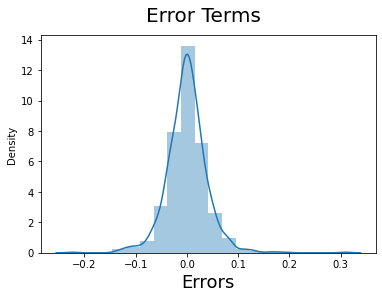

In [65]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)           

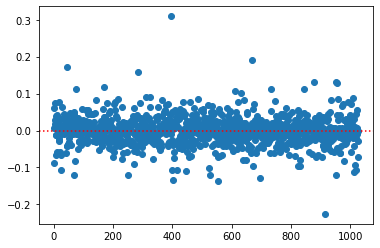

In [66]:
# Looking for patterns in the residuals

plt.scatter(np.arange(0,len(X_train),1), (y_train - y_pred_train))
plt.axhline(y=0, color='r', linestyle=':')
plt.show()

### Step 8: Lasso Regression

In [67]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [68]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [69]:
#Fitting Lasso model for alpha = 0.0001 and printing coefficients which have been penalised

alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [70]:
# Printing first 10 coefficients
lasso.coef_[:10]

array([ 0.        ,  0.08738113,  0.02278899,  0.12309423,  0.03170209,
        0.06794693,  0.00385614,  0.        , -0.01519019,  0.30333865])

In [71]:
# No. of features considered 
print("Total features fed to the model:", X_train.columns.size)

# No. of features considered 
print("features considered:", np.count_nonzero(lasso.coef_))

# No. of features elimiated
print("features eliminated:", lasso.coef_.size - np.count_nonzero(lasso.coef_))

Total features fed to the model: 306
features considered: 164
features eliminated: 142


In [72]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_score_train", r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_score_test:",r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS_train:",rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS_test:",rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE_train:",mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE_test:", mse_test_lr)
metric3.append(mse_train_lr**0.5)

r2_score_train 0.9461590343274496
r2_score_test: 0.8857261022772961
RSS_train: 1.7174286285545142
RSS_test: 0.8210832053675634
MSE_train: 0.0016706504168818232
MSE_test: 0.0031824930440603233


In [73]:
#Fitting Lasso model for alpha = 20 and printing coefficients which have been penalised

alpha20 = 20

lasso20 = Lasso(alpha=alpha20)
        
lasso20.fit(X_train, y_train) 

# Printing first 20 coefficients
lasso20.coef_[:20]

array([ 0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
       -0.,  0.,  0.,  0., -0., -0., -0.])

In [74]:
# No. of features considered 
print("Total features fed to the model:", X_train.columns.size)

# No. of features considered 
print("features considered:", np.count_nonzero(lasso20.coef_))

# No. of features eliminated
print("features eliminated:", lasso20.coef_.size - np.count_nonzero(lasso20.coef_))

Total features fed to the model: 306
features considered: 0
features eliminated: 306


In [75]:
y_pred_train20 = lasso20.predict(X_train)
y_pred_test20 = lasso20.predict(X_test)

print("r2_score_train", r2_score(y_train, y_pred_train20))
print("r2_score_test:",r2_score(y_test, y_pred_test20))
print("RSS_train:",np.sum(np.square(y_train - y_pred_train20)))
print("RSS_test:",np.sum(np.square(y_test - y_pred_test20)))
print("MSE_train:",mean_squared_error(y_train, y_pred_train20))
print("MSE_test:", mean_squared_error(y_test, y_pred_test20))

r2_score_train 0.0
r2_score_test: -0.0024710881519733885
RSS_train: 31.898176548310108
RSS_test: 7.202976276747718
MSE_train: 0.031029354618978704
MSE_test: 0.02791851270057255


Insights:
- When the alpha value increased from optimal value 0.0001 to 20, all the coefficients have become 0
- Model is underfitting
- R2 score value has become 0.
- Bias has increased significantly. 

Text(0.5, 0, 'Errors')

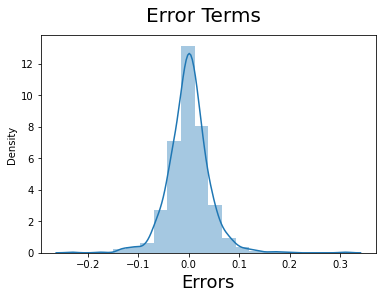

In [76]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)           

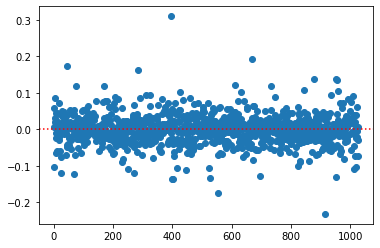

In [77]:
# Looking for patterns in the residuals

plt.scatter(np.arange(0,len(X_train),1), (y_train - y_pred_train))
plt.axhline(y=0, color='r', linestyle=':')
plt.show()

### Step9: Comparision of Metrics from all models

In [78]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'RMSE (Train)','RMSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )
rg_metric = pd.Series(metric2, name = 'Ridge Regression') # alpha = 2
ls_metric = pd.Series(metric3, name = 'Lasso Regression') # alpha = 0.0001

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.551579e-01,0.950006,0.946159
1,R2 Score (Test),-2.303602e+21,0.880499,0.885726
2,RSS (Train),1.430381e+00,1.594704,1.717429
3,RSS (Test),1.655189e+22,0.858639,0.821083
4,RMSE (Train),3.730176e-02,0.039386,0.040874
5,RMSE (Test),8.009657e+09,0.057689,0.040874


In [79]:
# Creating a dataframe with all coeffients from all models

betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns

betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

pd.set_option('display.max_rows', None)
betas

,Linear,Ridge,Lasso
LotFrontage,-1.812956e-02,0.001699,0.000000e+00
LotArea,1.084331e-01,0.074067,8.738113e-02
MasVnrArea,1.963613e-02,0.028067,2.278899e-02
BsmtFinSF1,1.560509e-01,0.111924,1.230942e-01
BsmtFinSF2,6.433616e-02,0.029224,3.170209e-02
BsmtUnfSF,1.125070e-01,0.062276,6.794693e-02
1stFlrSF,-1.010319e+11,0.115998,3.856139e-03
2ndFlrSF,-7.104530e+10,0.064787,0.000000e+00
LowQualFinSF,-2.371252e+10,-0.004288,-1.519019e-02
GrLivArea,1.098434e+11,0.147671,3.033386e-01


In [80]:
# Printing the top 5 significant features from Ridge model with alpha = 2

betas.nlargest(5, 'Ridge')['Ridge']

GrLivArea               0.147671
1stFlrSF                0.115998
BsmtFinSF1              0.111924
OverallQual_9           0.084733
Neighborhood_StoneBr    0.080901
Name: Ridge, dtype: float64

In [81]:
# Printing the top 5 significant features from Lasso model with alpha = 0.0001
betas.nlargest(5, 'Lasso')['Lasso']

GrLivArea               0.303339
BsmtFinSF1              0.123094
OverallQual_9           0.121218
Neighborhood_StoneBr    0.088677
LotArea                 0.087381
Name: Lasso, dtype: float64

### Conclusions
- Optimal lambda(alpha) value for <b>Ridge</b> regression model is <b>2</b>
- Optimal lambda(alpha) value for <b>Lasso</b> regression model is <b>0.0001</b>
- All the model R2 score is around 95%
- Top 5 significant features from Ridge model
    - GrLivArea               
    - 1stFlrSF                
    - BsmtFinSF1              
    - OverallQual_9           
    - Neighborhood_StoneBr    
- Top 5 significant features from Lasso model
    - GrLivArea               
    - BsmtFinSF1              
    - OverallQual_9           
    - Neighborhood_StoneBr   
    - LotArea          
- Lasso model gave an R2 score very close to what Ridge regression model has given. But was also able to eliminate 142 features. 
- So, <b>Lasso model should be preferred </b>as it gave a good R2 score with lesser no. of features, keeping the model simpler compared to the model generated by Ridge regression or base linear regression models

#### Subjective Questions

Question 1

What is the optimal value of alpha for ridge and lasso regression? 2.0 and 0.0001
What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? 
What will be the most important predictor variables after the change is implemented?




In [82]:
#Fitting Ridge model for alpha = 4 and printing (first 10) coefficients which have been penalised
alpha2 = 4
ridge2 = Ridge(alpha=alpha2)

ridge2.fit(X_train, y_train)
print(ridge2.coef_[:10])

[ 0.00667468  0.06047056  0.02991837  0.10050372  0.02096682  0.05049489
  0.10597976  0.05412117 -0.00393105  0.13163449]


In [83]:
y_pred_train = ridge2.predict(X_train)
y_pred_test = ridge2.predict(X_test)

metric4 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_score_train", r2_train_lr)
metric4.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_score_test:",r2_test_lr)
metric4.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("MSE_test:",rss1_lr)
metric4.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("MSE_test:",rss2_lr)
metric4.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE_test:",mse_train_lr)
metric4.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE_test:", mse_test_lr)
metric4.append(mse_test_lr**0.5)

r2_score_train 0.9462861656441766
r2_score_test: 0.8817774501077897
MSE_test: 1.7133733713687402
MSE_test: 0.8494551437089619
MSE_test: 0.0016667056141719263
MSE_test: 0.0032924617973215577


In [84]:
#Fitting Ridge model for alpha = 0.0002 and printing (first 10) coefficients which have been penalised

alpha2 =0.0002

lasso2 = Lasso(alpha=alpha2)
        
lasso2.fit(X_train, y_train) 

# Printing first 10 coefficients
lasso2.coef_[:10]

array([ 0.        ,  0.07443646,  0.02608368,  0.11683799,  0.02031393,
        0.05116113,  0.0160961 ,  0.        , -0.00230975,  0.29204543])

In [85]:
y_pred_train = lasso2.predict(X_train)
y_pred_test = lasso2.predict(X_test)

metric5 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_score_train", r2_train_lr)
metric5.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_score_test:",r2_test_lr)
metric5.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("MSE_test:",rss1_lr)
metric5.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("MSE_test:",rss2_lr)
metric5.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE_test:",mse_train_lr)
metric5.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE_test:", mse_test_lr)
metric5.append(mse_train_lr**0.5)

r2_score_train 0.9397713046669093
r2_score_test: 0.8896568912262744
MSE_test: 1.921185557009308
MSE_test: 0.7928396182127573
MSE_test: 0.0018688575457288987
MSE_test: 0.003073021776018439


In [86]:
rg_metric4 = pd.Series(metric4, name = 'Ridge_double_alpha')
ls_metric5 = pd.Series(metric5, name = 'Lasso_double_alpha')

final_metric = pd.concat([final_metric, rg_metric4, ls_metric5], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression,Ridge_double_alpha,Lasso_double_alpha
0,R2 Score (Train),9.551579e-01,0.950006,0.946159,0.946286,0.939771
1,R2 Score (Test),-2.303602e+21,0.880499,0.885726,0.881777,0.889657
2,RSS (Train),1.430381e+00,1.594704,1.717429,1.713373,1.921186
3,RSS (Test),1.655189e+22,0.858639,0.821083,0.849455,0.792840
4,RMSE (Train),3.730176e-02,0.039386,0.040874,0.040825,0.043230
5,RMSE (Test),8.009657e+09,0.057689,0.040874,0.057380,0.043230


In [87]:
# No. of features considered 
print("Total features fed to the model:", X_train.columns.size)

# No. of features considered 
print("features considered:", np.count_nonzero(lasso2.coef_))

# No. of features elimiated
print("features eliminated:", lasso2.coef_.size - np.count_nonzero(lasso2.coef_))

Total features fed to the model: 306
features considered: 122
features eliminated: 184


In [88]:
#betas_V2 = pd.DataFrame(index=X_train.columns)
#betas_V2.rows = X_train.columns

#betas['Linear'] = lm.coef_
betas['Ridge2'] = ridge2.coef_
betas['Lasso2'] = lasso2.coef_

pd.set_option('display.max_rows', None)
betas

,Linear,Ridge,Lasso,Ridge2,Lasso2
LotFrontage,-1.812956e-02,0.001699,0.000000e+00,0.006675,0.000000
LotArea,1.084331e-01,0.074067,8.738113e-02,0.060471,0.074436
MasVnrArea,1.963613e-02,0.028067,2.278899e-02,0.029918,0.026084
BsmtFinSF1,1.560509e-01,0.111924,1.230942e-01,0.100504,0.116838
BsmtFinSF2,6.433616e-02,0.029224,3.170209e-02,0.020967,0.020314
BsmtUnfSF,1.125070e-01,0.062276,6.794693e-02,0.050495,0.051161
1stFlrSF,-1.010319e+11,0.115998,3.856139e-03,0.105980,0.016096
2ndFlrSF,-7.104530e+10,0.064787,0.000000e+00,0.054121,0.000000
LowQualFinSF,-2.371252e+10,-0.004288,-1.519019e-02,-0.003931,-0.002310
GrLivArea,1.098434e+11,0.147671,3.033386e-01,0.131634,0.292045


In [89]:
print(betas.nlargest(5, ['Ridge2'])['Ridge2'])
print(betas.nlargest(5, ['Lasso2'])['Lasso2'])

GrLivArea               0.131634
1stFlrSF                0.105980
BsmtFinSF1              0.100504
OverallQual_9           0.084544
Neighborhood_StoneBr    0.072646
Name: Ridge2, dtype: float64
GrLivArea               0.292045
OverallQual_9           0.133045
BsmtFinSF1              0.116838
Neighborhood_StoneBr    0.075636
OverallQual_8           0.075138
Name: Lasso2, dtype: float64


Question 3

After building the model, you realised that the five most important predictor variables in the lasso model 
are not available in the incoming data. 
You will now have to create another model excluding the five most important predictor variables. 
Which are the five most important predictor variables now?


In [90]:
#Fitting Ridge model for alpha = 0.0001 and printing (first 10) coefficients which have been penalised

alpha3 =0.0001

lasso3 = Lasso(alpha=alpha3)

X_train_3 = X_train.drop(['GrLivArea', 'OverallQual_9', 'BsmtFinSF1', 'Neighborhood_StoneBr', 'OverallQual_8'],axis=1) 

lasso3.fit(X_train_3, y_train) 

# Printing first 10 coefficients
lasso3.coef_[:10]

array([-0.        ,  0.07954408,  0.03825641, -0.        , -0.04457164,
        0.39394719,  0.18214061,  0.00157595,  0.0483733 ,  0.02536232])

In [91]:
# No. of features considered 
print("Total features fed to the model:", X_train.columns.size)

# No. of features considered 
print("features considered:", np.count_nonzero(lasso3.coef_))

# No. of features elimiated
print("features eliminated:", lasso3.coef_.size - np.count_nonzero(lasso3.coef_))

Total features fed to the model: 306
features considered: 169
features eliminated: 132


In [92]:
betas_lasso3 = pd.DataFrame(index=X_train_3.columns)
betas_lasso3.rows = X_train_3.columns

betas_lasso3['Lasso3'] = lasso3.coef_

pd.set_option('display.max_rows', None)
betas_lasso3

,Lasso3
LotFrontage,-0.000000
LotArea,0.079544
MasVnrArea,0.038256
BsmtFinSF2,-0.000000
BsmtUnfSF,-0.044572
1stFlrSF,0.393947
2ndFlrSF,0.182141
LowQualFinSF,0.001576
GarageArea,0.048373
WoodDeckSF,0.025362


In [93]:
print(betas_lasso3.nlargest(5, ['Lasso3'])['Lasso3'])

1stFlrSF                0.393947
2ndFlrSF                0.182141
LotArea                 0.079544
3SsnPorch               0.063723
Neighborhood_Crawfor    0.063107
Name: Lasso3, dtype: float64


## Conclusions
- Optimal lambda(alpha) value for <b>Ridge</b> regression model is <b>2</b>
- Optimal lambda(alpha) value for <b>Lasso</b> regression model is <b>0.0001</b>
- Model accuracy is around 95%
- Top 5 significant features from Ridge model
    - GrLivArea               
    - 1stFlrSF                
    - BsmtFinSF1              
    - OverallQual_9           
    - Neighborhood_StoneBr    
- Top 5 significant features from Lasso model
    - GrLivArea               
    - BsmtFinSF1              
    - OverallQual_9           
    - Neighborhood_StoneBr   
    - LotArea          
- Lasso model gave an R2 score very close to what Ridge regression model has given. But was also able to eliminate 142 features. 
- So, <b>Lasso model should be preferred </b>as it gave a good R2 score with lesser no. of features, keeping the model simpler compared to the model generated by Ridge regression or base linear regression models